# _Herschel_ SPIRE Spectral Feature Finder

## A notebook with simple examples on using the Spectral Feature Finder products

**Authors:** Jeremy Scott (1), Ivan Valtchanov (2), Christopher Benson (1) and Locke Spencer (1).

(1) University of Lethbridge, Dr. Locke Spencer's Lab, E736, Alberta, Canada </br>
(2) Herschel Science Centre, European Space Astronomy Centre, European Space Agency

**Version:** 1.0

**Date:** 02 Apr 2019

### Introduction

The Herschel/SPIRE Spectral Feature Finder (FF) is an automated tool which detects significant spectral features within SPIRE Fourier Transform Spectrometer (FTS) spectral data. The FF is designed to facilitate data-mining and preliminary analysis of SPIRE spectral data and is not a replacement for detailed scientific analysis. A full introduction to the FF routine and products is presented at http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/spectral_feature_catalogue/SpectralFeatureFinder_releaseNote.html The FF products can be accessed from https://www.cosmos.esa.int/web/herschel/spire-spectral-feature-catalogue. In this notebook we provide examples of how to search FF products for spectral lines or sources on interest, and include sample code for visually displaying the results and estimating integrated line flux. 

The full FF products can be downloaded from the link above, however, in this notebook we will only download select products when necessary. Products will be downloaded from the `archive` defined below and will be placed in a chosen directory which we will assigned to the variable `dataDir`. The `archive` has a directory structure identical to the FF products you can download from the link above.

To begin, a few Python modules will need to be imported. The standard Anaconda distribution is recommended as it includes most of these packages by default. However, Anaconda does not ship with the spectral-cube or lmfit packages and likely need to be installed by the user.

### Requirements

This notebook was developed and needs python 3.7 and the necessary packages are listed in [environment.yml](environment.yml) file. You can use the file with conda:

```
conda env create -f environment.yml
```
---

In [2]:
import os
import io
import requests
import gzip
import csv
import tarfile
import urllib3
http = urllib3.PoolManager()

import numpy as np
from lmfit import Model

from astropy import units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table

from spectral_cube import SpectralCube

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# define the URL for the FTS Spectral Feature Catalogue
archive = 'http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/spectral_feature_catalogue'

# the work folder where the data will be downloaded. It will be used as a simple cache folder too.
dataDir = os.path.join(os.path.expanduser('~'),'tmp/HerschelData')
if (not os.path.isdir(dataDir)):
    print (f'{dataDir} does not exist!')
    print ('Please set dataDir to point to an already existing folder')
else:
    print (f"INFO: all temprary files and downloads will be stored in {dataDir}")

INFO: all temprary files and downloads will be stored in /Users/ivaltcha/tmp/HerschelData


### Searching the Catalogue

Searching the features catalogue for features meeting a specific search criteria is done most efficiently with the the SPIRE Automated Feature Extraction Catalogue (SAFECAT). The SAFECAT is a fits table which contains a row entry for each feature detected by the FF. Below we demonstrate how to retrieve and search the SAFECAT for detected features within a user-defined frequency range.

In [4]:
SAFECAT = Table.read(f'{archive}/SpireAutomatedFeatureExtractionCATalogue/SAFECAT_v2_restFrame.fits.gz')
SAFECAT.info()

<Table length=167525>
     name       dtype   unit   format                           description                           n_bad
-------------- ------- ------ -------- -------------------------------------------------------------- -----
         obsid   int32                                                                      The OBSID     0
         opDay   int32                                                   The Herschel Operational Day     0
     frequency float64    GHz  {:8.3f}                              Observed frequency of the feature     0
frequencyError float64    GHz  {:8.3f}                                 Error on the derived frequency     0
 restFrameFreq float64    GHz  {:8.3f}                            Rest-frame frequency of the feature     0
           SNR float64        {:10.1f}                                          Signal-to-noise ratio     0
         array  bytes3                                                Detector or detector array name     0
      

In [5]:
# frequency range
freqRange = (806.0, 809.0)  #GHz
restFrame = True

column = 'frequency'
if restFrame:
    column = 'restFrameFreq'

ind = np.where((SAFECAT[column] <= max(freqRange)) & (SAFECAT[column] >= min(freqRange)))[0]
out = SAFECAT[ind]
out

obsid,opDay,frequency,frequencyError,restFrameFreq,SNR,array,row,column,ra,dec,featureFlag,velocity,velocityError,vFlag,extent,calibration,sampling,hpdp,bgs,nccFlag
,,GHz,GHz,GHz,,,,,deg,deg,,km / s,km / s,,,,,,,
int32,int32,float64,float64,float64,float64,bytes3,int32,int32,float64,float64,float64,float64,float64,bytes5,bytes12,bytes14,bytes12,int32,int32,int32
1342187893,209,773.972,0.045,806.645,18.5,SLW,-1,-1,194.0593,56.8737,0.0,12655.6,34.8,XCOR,pointLike,pointSource,sparse,0,0,0
1342187904,210,806.655,0.006,806.677,256.1,SLW,-1,-1,309.7546,42.3286,0.0,8.2,15.5,FF,semiExtended,pointSource,sparse,0,0,0
1342187904,210,806.647,0.004,806.665,431.5,SLW,-1,-1,309.7546,42.3286,1.0,6.6,13.5,FF,semiExtended,extendedSource,sparse,0,0,0
1342188186,217,806.672,0.052,806.645,18.7,SLW,-1,-1,304.3734,36.8084,0.0,-10.0,15.7,XCOR?,extended,pointSource,sparse,0,0,0
1342188186,217,806.622,0.030,806.595,26.1,SLW,-1,-1,304.3734,36.8084,1.0,-10.0,15.7,XCOR?,extended,extendedSource,sparse,0,0,0
1342188188,217,806.659,0.045,806.634,31.6,SLW,-1,-1,304.4226,36.7062,0.0,-9.4,18.1,XCOR?,extended,pointSource,sparse,0,0,0
1342188188,217,806.636,0.035,806.611,33.4,SLW,-1,-1,304.4226,36.7062,1.0,-9.4,18.1,XCOR?,extended,extendedSource,sparse,0,0,0
1342188189,217,806.754,0.075,806.773,13.7,SLW,-1,-1,304.4688,36.7134,0.0,7.2,57.7,XCOR?,extended,pointSource,sparse,0,0,0


The `out` is a table extracted from the full SAFECAT with all entries that match the frequency search range. Queries using other search criteria can be accomplished using a similar format. Below we demonstrate queries based on radial velocity and observation identification number (obsid).

In [6]:
# velociy range
velRange = (1000.0, 1020.0) #km/s
column = 'velocity'

ind = np.where((SAFECAT[column] <= max(velRange)) & (SAFECAT[column] >= min(velRange)))[0]
print(f"Found {len(ind)} features within a velocity range of {velRange} km/s")
#out = SAFECAT[ind]

Found 4 features within a velocity range of (1000.0, 1020.0) km/s


In [7]:
# obsid
obsid = 1342243604
column = 'obsid'

ind = np.where(SAFECAT[column] == obsid)[0]
print(f"Found {len(ind)} features with OBSID {obsid}")
#out = SAFECAT[ind]

Found 438 features with OBSID 1342243604


As a final example, we demonstrate how to query results based on sky coordinates. Herschel uses the equatorial coordinate system with right ascension (RA) and declination (DEC) recorded in units of degrees. Converting from HH:MM:SS to degrees can be accomplished easily using the `SkyCoord` method in the astropy module (see documentation for proper implementation).

In [8]:
# coordinates
ra_in = '21 7 1.7' # HH:MM:SS
dec_in = '42 14 11' # DD:MM:SS

# conversion
c = SkyCoord(ra_in, dec_in, frame='icrs', unit=(u.hourangle, u.deg))

# search radius
radius = 0.5 * u.arcmin #arcmin

In [9]:
# we use astropy.coordinates methods for catalogue matching and separarion
catalog = SkyCoord(SAFECAT['ra'],SAFECAT['dec'],frame='icrs',unit=(u.deg,u.deg))
d2d = c.separation(catalog)
in_radius = d2d <= radius
ind = np.where(in_radius)[0]

print (f"Found {len(ind)} features within a radius of {radius} about {c}")
out = SAFECAT[ind]
obsids = np.unique(out['obsid'])
print(f"Number of unique obsids: {len(obsids)}")

Found 1093 features within a radius of 0.5 arcmin about <SkyCoord (ICRS): (ra, dec) in deg
    (316.75708333, 42.23638889)>
Number of unique obsids: 32


### Visual Inspection
The FF products include postcards for quick inspection of the FF results. These postcards can be opened using Python as demonstrated below. To do this efficiently, one must know the obsid, calibration scheme, and observation mode for the source of interest. This information is encoded in the SAFECAT, and by extension the `out` sub-table using the column headings/keys "obsid", "calibration", and "sampling", respectively.

In [10]:
obsid = 1342191234
column = 'obsid'

ind = np.where(SAFECAT[column] == obsid)[0]
out = SAFECAT[ind]

cal = out['calibration'][0] # options: 'extended', 'pointSource'
obs_mod = out['sampling'][0] # options: 'full', 'sparse'
hpdp = int(out['hpdp'][0])
bgs = int(out['bgs'][0])
specType = ''
if hpdp:
    specType = 'HPDP'
elif bgs:
    specType = 'BGS'
else:
    specType = 'SPG'

In [11]:
def getPaths(obsid, cal, obs_mod):
    """
    utility def to return the URLs for the postcard, the features catalogue and the continuum file
    """
    pntDir = f'{archive}/HRpointProducts' # directory for point source calibrated sparse observations
    extDir = f'{archive}/HRextProducts' # directory for extended source calibrated sparse observations
    mapDir = f'{archive}/HRmapping' # directory for extended source calibrated full sampling observations (mapping)
    if ('full' in obs_mod or 'intermediate' in obs_mod) and ('extended' in cal):
        pFile = f'{mapDir}/postcards/{obsid}_postcard_comb_2x3.png'
        obsFile = f'{mapDir}/featureCatalogues/{obsid}_featuresFound.fits'
        contFile = f'{mapDir}/continuumParameters/{obsid}_fittedContinuumParameters.fits'
    elif ('sparse' in obs_mod) and (cal == 'pointSource'):
        # PNG postcards are in a hidden folder
        pFile = f'{archive}/.images/postcards_png/{obsid}_postcard_pnt.png'
        obsFile = f'{pntDir}/featureCatalogues/{obsid}_featuresFound_pnt.fits'
        contFile = f'{pntDir}/continuumParameters/{obsid}_fittedContinuumParameters_pnt.fits'
    elif ('sparse' in obs_mod) and ('extended' in cal):
        pFile = f'{archive}/.images/postcards_png/{obsid}_postcard_ext.png'
        obsFile = f'{extDir}/featureCatalogues/{obsid}_featuresFound_ext.fits'
        contFile = f'{extDir}/continuumParameters/{obsid}_fittedContinuumParameters_ext.fits'
    else:
        print('Invalid inputs')
        pFile = None
        obsFile = None
        contFile = None
        
    # now check if those files are available
    r = http.request('HEAD',pFile)
    if (r.status != 200):
        print ("Warning, postcard file {pFile} not found")
        pFile = None
    r = http.request('HEAD',obsFile)
    if (r.status != 200):
        print ("Warning, featureFinder table {obsFile} not found")
        obsFile = None
    r = http.request('HEAD',contFile)
    if (r.status != 200):
        print ("Warning, continuum file {contFile} not found")
        contFile = None
    #
    return pFile, obsFile, contFile

Postcard location: http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/spectral_feature_catalogue/.images/postcards_png/1342191234_postcard_pnt.png


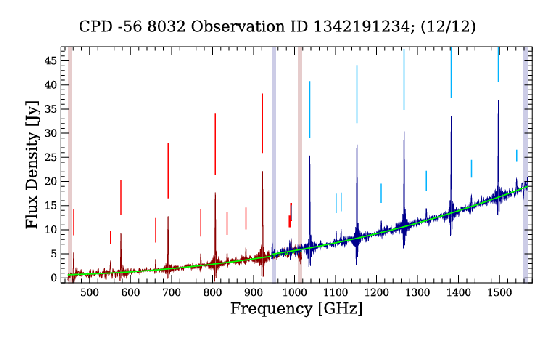

In [12]:
pURL, obsURL, contURL = getPaths(obsid, cal, obs_mod)
print(f"Postcard location: {pURL}")
img = plt.imread(pURL)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

The `obsURL` and `contURL` variables point to the files containing the features catalogue and fitted continuum parameters for the specified observation. These will be used later.

It is also possible to download SPIRE spectral data directly from the Herschel Science Archive (HSA) using Python. These data can then be plotted along with features detected by the FF meeting a search criteria. Manipulating SPIRE spectral cubes is accomplished using the "spectral-cube" package of astropy, which may need to be installed by the user. SPIRE spectral data can be retrieved using the function `getSpireFtsData` defined below. 

Note that the `getSpireFtsData` function returns both "naive" and "convolved" hyper-spectral cubes, and has options for both "apodized" and "unapodized" spectra. FF products, however, are only available for unapodized spectra. Additionally, for sparse observations, the `getSpireFtsData` function is configured to return spectra from only the central "SLWC3" and "SSWD4" detectors. For sparse observations, FF products are only available for unapodized spectra from the central detectors. 

It should also be noted that many sparse observations processed by the FF use Highly Processed Data Products (HPDPs; http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/cal_targets/) or Background Subtracted data (BGS; http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/BKGS/). These spectra are stored in a different location that the Standard Product Generation (SPG) spectra. To retrieve to spectrum processed by the FF, the appropriate data type (`specType`) must be specified in the `getSpireFtsData` function. 

In [13]:
def getSpireFtsData(obsid, cal, obs_mod, specType, apod=False, cache=True, tmpDir=""):
    """
    Using the HTTP access to HAIO, retrieve the level-2 products in a tar file
    and extract only the requested fits files
    
    cubeType can be 'convol' or 'naive'
    apod controls whether to extract the apodized version (if True)
    
    simple caching is impemented, checking of a tar file with the same name (OBSID based) already exists
    at the default folder.
    """
    
    spg_url = "http://archives.esac.esa.int/hsa/aio/jsp/"
    hpdp_url = "http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/cal_targets/SPIREspec_calibrators/"
    bgs_url = "http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/BKGS/spectra/"
    
    if obs_mod != 'full':
        detectors = ['SLWC3', 'SSWD4']
        specDets = {det:[] for det in detectors}
        headers = {det:[] for det in detectors}
    if specType == 'SPG':
        vers = '_spg_'
        if (apod): 
            vers = '_spgApod_'
        tarFile = tmpDir + "/%i_FTS_level2.tar"%obsid
        if (os.path.isfile(tarFile) and cache):
            print ("Found an already existing tar file for OBSID %i. Will Use it"%obsid)
        else:
            haioRequest = spg_url + "product.jsp?PROTOCOL=HTTP&OBSERVATION_ID=%i&PRODUCT_LEVEL=Level2"%obsid
            print ("Downloading level-2 data from the Herschel Science Archive. May take a while... be patient")
            r = requests.get(haioRequest)
            with open(tarFile, "wb") as tmp:
                tmp.write(r.content)
        # now read the downloaded tar file.
        with tarfile.open(tarFile,'r') as tar:
            if obs_mod == 'full': # mapping observations 
                cube = {}
                headers = {}
                for member in tar.getmembers():
                    if (('_20ssc_' in member.name) and (vers in member.name)):
                        ctype = 'naive'
                        if ('convol' in member.name):
                            ctype = 'convol'
                        f=tar.extractfile(member)
                        xx = fits.open(gzip.open(io.BytesIO(f.read())))
                        detx = xx[0].header['DETECTOR']
                        res = xx[0].header['PROC_RES']
                        # comined key for the output dictionary
                        xkey = "%s_%s_%s"%(detx,res,ctype)
                        cubeData = xx['image'].data
                        header = xx['image'].header
                        header["CTYPE3"] = "FREQ"
                        cube[xkey]= SpectralCube(data=cubeData, wcs=WCS(header))
                        headers[xkey] = xx[0].header
                return cube, headers, header
            elif obs_mod == 'sparse': # sparse observations
                calDict = {'pointSource':'point', 'extended':'ext'} 
                for member in tar.getmembers():
                    if (('_20s' in member.name) and (vers in member.name) and (calDict[cal] in member.name)):
                        f=tar.extractfile(member)
                        xx = fits.open(gzip.open(io.BytesIO(f.read())))
    else:
        if specType == 'HPDP':
            r = requests.get(hpdp_url)
            url = hpdp_url
        elif specType == 'BGS':
            r = requests.get(bgs_url)
            url = bgs_url
        else:
            print("Invalid specType")
            return False, False
        i_start = int(r.text.find(str(obsid)))
        if i_start == -1:
            print("No %s for observation %i"%(specType,obsid))
            return False, False
        i_end = i_start + int(r.text[i_start:].find('gz')) + 2
        gzFile = tmpDir + "/" + r.text[i_start:i_end]
        if (os.path.isfile(gzFile) and cache):
            print ("Found an already existing gz file for OBSID %i. Will Use it"%obsid)
        else:
            haioRequest = url + r.text[i_start:i_end]
            print ("Downloading %s data from the Archive. May take a while... be patient"%specType)
            r = requests.get(haioRequest)
            with open(gzFile, "wb") as tmp:
                tmp.write(r.content)
        xx = fits.open(gzip.open(gzFile))
    header0 = xx[0].header
    for det in detectors:
        specDets[det] = xx[det].data
        headers[det] = xx[det].header
    return specDets, header0, headers

### Sparse FF Producs and SPIRE Spectral Datasets

Currently our code is pointed at the observation 1342191234 which is a point source calibrated sparse observation. To retrieve the SPIRE level-2 spectral data for this observation, we call the `getSpireFtsData` function as demonstrated below.

In [14]:
specData, header0, headers = getSpireFtsData(obsid, cal, obs_mod, specType, apod=False, cache=True, tmpDir=dataDir)

print(f"\nData keys: {specData.keys()}")
print(f"Header keys: {headers.keys()}")
print(f"Target: {header0['OBJECT']}")

Found an already existing tar file for OBSID 1342191234. Will Use it

Data keys: dict_keys(['SLWC3', 'SSWD4'])
Header keys: dict_keys(['SLWC3', 'SSWD4'])
Target: CPD -56 8032


As can be seen, the "specData" and "headers" dictionaries contain entries for both central detectors. We will focus primarily on the frequency and flux axes of the spectral data. For more details about the data structure of SPIRE observations, the reader is referred to [the SPIRE data reduction guide](http://herschel.esac.esa.int/hcss-doc-15.0/load/spire_drg/html/spire_drg.html).

With the spectral data in hand, we can now generate a plot of the spectral data and include the fitted continuum and additional lines to indicate spectral features detected by the FF. In principle, we could search the SAFECAT for the desired features as demonstrated above. This time, however, we will extract the desired lines from the features catalogue specific to the 1342191234 observation. The location of the observation specific features catalogue and its fitted continuum parameters are currently stored in the `obsFile` and `contFile` variables, respectively, defined above. When plotting lines to indicated the position of desired features, these lines will be proportional to the associated SNRs of the features, much like the lines in the FF postcards.

In [15]:
# retrieve observation specific catalogue and continuum, directly from the URL
data = Table.read(obsURL)
data.info

<Table length=24>
     name       dtype  unit
-------------- ------- ----
     frequency float64  GHz
frequencyError float64  GHz
           SNR float64     
      detector  bytes5     
   featureFlag float64     
       nccFlag   int32     

In [16]:
cont = Table.read(contURL)
cont.info

<Table length=2>
  name    dtype 
-------- -------
detector  bytes5
      p0 float64
   p0err float64
      p1 float64
   p1err float64
      p2 float64
   p2err float64
      p3 float64
   p3err float64

In [17]:
# unpack data for convenience
features = data['frequency']
snr = data['SNR']
detector = data['detector']
velocity = data.meta['RV']
velocity_error = data.meta['RV_ERR']

# select lines of interest
freqRange = (900.0, 1500.0)
ind = np.where((features >= min(freqRange)) & (features <= max(freqRange)))[0]
print (f"Found {len(ind)} features")

Found 14 features


In [18]:
# generate fitted continuum
x_slw, y_slw = specData['SLWC3']['wave'], specData['SLWC3']['flux']
x_ssw, y_ssw = specData['SSWD4']['wave'], specData['SSWD4']['flux']
cont_slw = cont['p0'][0] + cont['p1'][0]*x_slw + cont['p2'][0]*x_slw**2 + cont['p3'][0]*x_slw**3
cont_ssw = cont['p0'][1] + cont['p1'][1]*x_ssw + cont['p2'][1]*x_ssw**2 + cont['p3'][1]*x_ssw**3
flux_range = (max([max(y_slw),max(y_ssw)]) - min([min(y_slw),min(y_ssw)]))
offset = flux_range*0.05
scale = flux_range/max(snr)/2.0

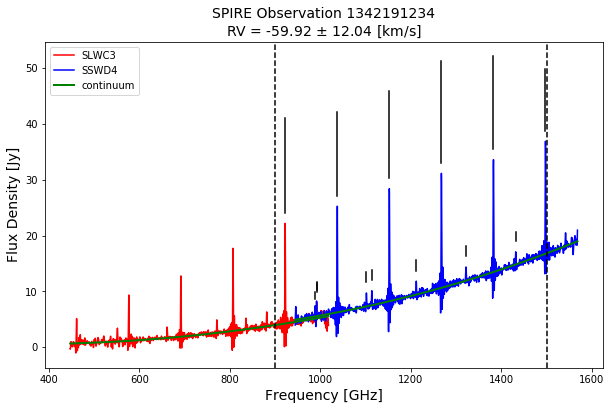

In [19]:
# plotting
fig = plt.figure(0, figsize=(10,6))
plt.clf()
plt.title(f"SPIRE Observation {obsid}\nRV = {velocity:.2f} $\\pm$ {velocity_error:.2f} [km/s]", fontsize=14)
plt.plot(x_slw, y_slw, 'r', label='SLWC3')
plt.plot(x_ssw, y_ssw, 'b', label='SSWD4')
plt.plot(x_slw, cont_slw, 'g', linewidth=2.0, label='continuum')
plt.plot(x_ssw, cont_ssw, 'g', linewidth=2.0)
for i in ind:
    freq = features[i]
    sn = snr[i]*scale
    det = detector[i]
    base = specData[det]['flux'][np.where(min(abs(specData[det]['wave'] - freq)) == 
                                          abs(specData[det]['wave'] - freq))[0]]
    plt.plot([freq, freq], [base+offset, base+offset+sn], 'k')
limits = plt.ylim()
plt.plot([min(freqRange), min(freqRange)],[min(limits), max(limits)], '--k')
plt.plot([max(freqRange), max(freqRange)],[min(limits), max(limits)], '--k')
plt.ylim(limits)
plt.xlabel(f"{headers['SLWC3'].comments['TTYPE1']} [{headers['SLWC3']['TUNIT1']}]", fontsize=14)
plt.ylabel(f"{headers['SLWC3'].comments['TTYPE2']} [{headers['SLWC3']['TUNIT2']}]", fontsize=14)
plt.legend(loc=0);

Only features at frequencies in (900,1500) are shown as this was the selection criteria earlier on.

### Non-standard observations

Note that observations 1342227785 and 1342227778 are treated somewhat differently than other sparse observations in the FF products due to their irregular spatial sampling (see release notes). As such, users must be careful when accessing these data from the HSA, and the correct prefix `100` or `200` for beam steering mirror position 1 and 2, respectively, must be added to the obsid when searching for the corresponding postcards.

### Mapping FF Producs and SPIRE Spectral Datasets

We now turn to mapping observations. SPIRE data for mapping observations is packaged into "spectral cubes" (or hyper-spectral cubes) which are 3-dimensional data structures. Two axes correspond to pixel coordinates which represent different locations on-sky. The third axis corresponds to the spectral data. A pixel with spectral dimension is sometimes called _spaxel_.

Various cubes for the same mapping observation can be accessed from the HSA and retrieved using the `getSpireFtsData` function. FF products, however, are only available for High Resolution (HR) unapodized SLW and SSW convolved cubes. Details about the various cubes can be found in [the SPIRE data reduction guide](http://herschel.esac.esa.int/hcss-doc-15.0/load/spire_drg/html/spire_drg.html).

We begin by reassigning some variables, and retrieving the SPIRE data for a mapping observation.

Postcard location: http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/spectral_feature_catalogue/HRmapping/postcards/1342192174_postcard_comb_2x3.png


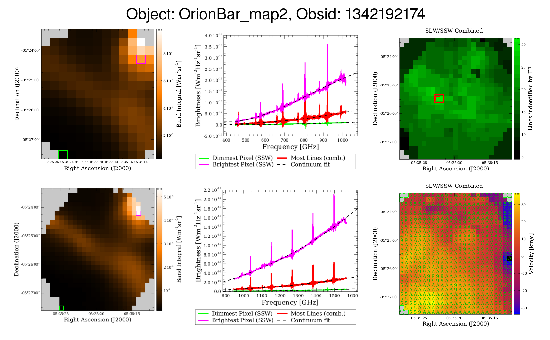

In [20]:
obsid = 1342192174
cal = 'extended'
obs_mod = 'full'
specType = 'SPG'

pURL, obsURL, contURL = getPaths(obsid, cal, obs_mod)
print(f"Postcard location: {pURL}")
img = plt.imread(pURL)
plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [21]:
specData, header0, headers = getSpireFtsData(obsid, cal, obs_mod, specType, apod=False, cache=True, tmpDir=dataDir)
cube_slw, cube_ssw = specData['SLW_HR_convol'], specData['SSW_HR_convol']
header_slw, header_ssw = cube_slw.header, cube_ssw.header
d_slw, d_ssw = header_slw['CDELT2'], header_ssw['CDELT2']  # pixel widths of SLW and SSW maps, respectively
for kk in header0.keys(): target = header0[kk]["OBJECT"] ; break

Found an already existing tar file for OBSID 1342192174. Will Use it


In [22]:
slw_shape = cube_slw.shape
ssw_shape = cube_ssw.shape
print (f'Target: {target}')
print(f"SLW Cube \n Shape: {slw_shape}; {slw_shape[0]} Frequency points, {slw_shape[1]} Rows, {slw_shape[2]} Columns", \
       f"\n Pixel width: {d_slw*3600:.1f} [arcsec]")
print(f"SSW Cube \n Shape: {ssw_shape}; {ssw_shape[0]} Frequency points, {ssw_shape[1]} Rows, {ssw_shape[2]} Columns", \
       f"\n Pixel width: {d_ssw*3600:.1f} [arcsec]")

Target: OrionBar_map2
SLW Cube 
 Shape: (1905, 15, 13); 1905 Frequency points, 15 Rows, 13 Columns 
 Pixel width: 17.5 [arcsec]
SSW Cube 
 Shape: (2082, 27, 25); 2082 Frequency points, 27 Rows, 25 Columns 
 Pixel width: 9.5 [arcsec]


As can be inferred from the dimensions of the SLW and SSW maps, in addition to their respective pixel widths, the SLW and SSW maps do not occupy the same footprint on-sky. This disparity can be easily seen in the mapping postcard. As such, one needs to take care when selecting SLW and SSW spaxels if one wishes to inspect the spectra form the same location on-sky with both maps. 

Below we demonstrate how to find the nearest SLW spaxel given an initial SSW spaxel using the FF products. We perform this operation with the observation specific features catalogue but the process in nearly identical when performed on the SAFECAT.

In [23]:
# extract data from observation specific features catalogue
# cannot use Table for multi-extension tables
hdulist = fits.open(obsURL)
hdulist.info()
FF_data = hdulist[1].data
velocity_map = hdulist[2].data
header = hdulist[1].header
hdulist.close()

Filename: /Users/ivaltcha/.astropy/cache/download/py3/03a994f9a5a66024c7941ed25b403608
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      65   ()      
  1  data          1 BinTableHDU    148   6573R x 13C   [1D, 1D, 1D, 3A, 1K, 1K, 1D, 1D, 1D, 1D, 1D, 3A, 1J]   
  2  velocity      1 BinTableHDU    128   27R x 25C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  3  velocityError    1 BinTableHDU    128   27R x 25C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  4  vFlags        1 BinTableHDU    153   27R x 25C   [6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A]   
  5  nLines        1 BinTableHDU    128   27R x 25C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  6  arrays        1 BinTableHDU    153   27R x 25C  

In [24]:
# reference SSW pixel (SPIRE data)
c_col = int(header_ssw['CRPIX1'])-1
c_row = int(header_ssw['CRPIX2'])-1
c_ra, c_dec = header_ssw['CRVAL1'], header_ssw['CRVAL2']
pix_coord = SkyCoord(c_ra, c_dec, frame='icrs', unit=(u.deg, u.deg))
print(f"SSW pixel {c_row, c_col} has coordinates {pix_coord}")

SSW pixel (13, 12) has coordinates <SkyCoord (ICRS): (ra, dec) in deg
    (83.832625, -5.42455556)>


In [25]:
# get indicies for all entries from reference SSW pixel (FF products)
ssw_ind = np.where(FF_data['array'] == 'SSW')[0]
ssw_coord = SkyCoord(FF_data['ra'][ssw_ind], FF_data['dec'][ssw_ind], frame='icrs', unit=(u.deg, u.deg))
d2d = pix_coord.separation(ssw_coord)
ssw_match = np.where(abs(d2d.deg) <= d_ssw/10.0) # not using '==' because of potential rounding 

ssw_ra, ssw_dec = np.unique(FF_data['ra'][ssw_ind][ssw_match]), np.unique(FF_data['dec'][ssw_ind][ssw_match])
ssw_row, ssw_col = np.unique(FF_data['row'][ssw_ind][ssw_match]), np.unique(FF_data['column'][ssw_ind][ssw_match])

# check that we are looking at the same on-sky location
if (min(abs(ssw_ra - c_ra)) > d_ssw/2.0) or (min(abs(ssw_dec - c_dec)) > d_ssw/2.0):
    print('SPIRE data and FF product coordinates do NOT match within half resolution of SSW mapping pixel.')
    print(f"FF Data: RA = {ssw_ra} Dec = {ssw_dec}")
    print(f"SPIRE: RA = {c_ra} Dec = {c_dec}")
else:
    print('SPIRE data and FF product coordinates DO match within half resolution of SSW mapping pixel.')
    print(f"FF SSW pixel {*ssw_row, *ssw_col} has coordinates {*ssw_ra, *ssw_dec} [deg]")

SPIRE data and FF product coordinates DO match within half resolution of SSW mapping pixel.
FF SSW pixel (13, 12) has coordinates (83.832625, -5.424555555555556) [deg]


In [26]:
# get indicies for all entries from SLW pixel nearest central SSW pixel (FF products)
slw_ind = np.where(FF_data['array'] == 'SLW')[0]
slw_coord = SkyCoord(FF_data['ra'][slw_ind], FF_data['dec'][slw_ind], frame='icrs', unit=(u.deg, u.deg))
d2d = pix_coord.separation(slw_coord)
slw_match = np.where((min(abs(d2d.deg)) == abs(d2d.deg)) & (abs(d2d.deg) <= np.sqrt(2)*d_slw))

slw_ra, slw_dec = np.unique(FF_data['ra'][slw_ind][slw_match]), np.unique(FF_data['dec'][slw_ind][slw_match])
slw_row, slw_col = np.unique(FF_data['row'][slw_ind][slw_match]), np.unique(FF_data['column'][slw_ind][slw_match])

print(f"\n     row  column\nSLW {slw_row[0]:4} {slw_col[0]:4}\nSSW {ssw_row[0]:4} {ssw_col[0]:4}")
print(f"\nFF coordinates of central SSW pixel = ({ssw_ra[0]:.4f}, {ssw_dec[0]:.4f}) [deg]")
print(f"FF coordinates of nearest SLW pixel = ({slw_ra[0]:.4f}, {slw_dec[0]:.4f}) [deg]")


     row  column
SLW    7    6
SSW   13   12

FF coordinates of central SSW pixel = (83.8326, -5.4246) [deg]
FF coordinates of nearest SLW pixel = (83.8326, -5.4246) [deg]


As can be seen from the above printout, we have successfully located the SLW pixel nearest the central SSW pixel.

Having determined which SLW and SSW pixels we wish to inspect, we can now generate a plot similar to the one generated for our example sparse observation. 

In [27]:
# organize FF results 
features, snr, array = [], [], []
#
features.extend(FF_data['frequency'][slw_ind][slw_match])
snr.extend(FF_data['snr'][slw_ind][slw_match])
array.extend(FF_data['array'][slw_ind][slw_match])
#
features.extend(FF_data['frequency'][ssw_ind][ssw_match])
snr.extend(FF_data['snr'][ssw_ind][ssw_match])
array.extend(FF_data['array'][ssw_ind][ssw_match])
#
features = np.array(features)
slw_velocity, ssw_velocity = np.mean(FF_data['velocity'][slw_ind][slw_match]), np.mean(FF_data['velocity'][ssw_ind][ssw_match])
slw_vel_error, ssw_vel_error = np.mean(FF_data['velocityError'][slw_ind][slw_match]), np.mean(FF_data['velocityError'][ssw_ind][ssw_match])
# organize SPIRE data
# this two lines work for spectral_cube version 0.4.3 or above
x_slw, y_slw = cube_slw.spectral_axis.value/1.0e9, cube_slw.unmasked_data[:,slw_row[0],slw_col[0]].value
x_ssw, y_ssw = cube_ssw.spectral_axis.value/1.0e9, cube_ssw.unmasked_data[:,ssw_row[0],ssw_col[0]].value
#
# for spectral_cube versions earlier than 0.4.3
#x_slw, y_slw = cube_slw.spectral_axis.value/1.0e9, cube_slw[:,slw_row[0],slw_col[0]].value
#x_ssw, y_ssw = cube_ssw.spectral_axis.value/1.0e9, cube_ssw[:,ssw_row[0],ssw_col[0]].value
flux = {'SLW':y_slw, 'SSW':y_ssw}
wave = {'SLW':x_slw, 'SSW':x_ssw}

In [28]:
# retrieve and generate the continua
hdulist = fits.open(contURL)
cont_data = hdulist[1].data
hdulist.close()

cont_slw_ind = np.where((cont_data['row'] == slw_row[0]) & (cont_data['column'] == slw_col[0]) & (cont_data['array'] == 'SLW'))[0]
cont_ssw_ind = np.where((cont_data['row'] == ssw_row[0]) & (cont_data['column'] == ssw_col[0]) & (cont_data['array'] == 'SSW'))[0]

cont_data_slw = {key:vals for (key, vals) in zip(cont_data.names, cont_data[cont_slw_ind[0]])}
cont_data_ssw = {key:vals for (key, vals) in zip(cont_data.names, cont_data[cont_ssw_ind[0]])}

cont_slw = cont_data_slw['p0'] + cont_data_slw['p1']*x_slw + cont_data_slw['p2']*x_slw**2 + cont_data_slw['p3']*x_slw**3 
cont_ssw = cont_data_ssw['p0'] + cont_data_ssw['p1']*x_ssw + cont_data_ssw['p2']*x_ssw**2 + cont_data_ssw['p3']*x_ssw**3
#
flux_range = (max([max(y_slw),max(y_ssw)]) - min([min(y_slw),min(y_ssw)]))
offset = flux_range*0.05
scale = flux_range/max(snr)/2.0

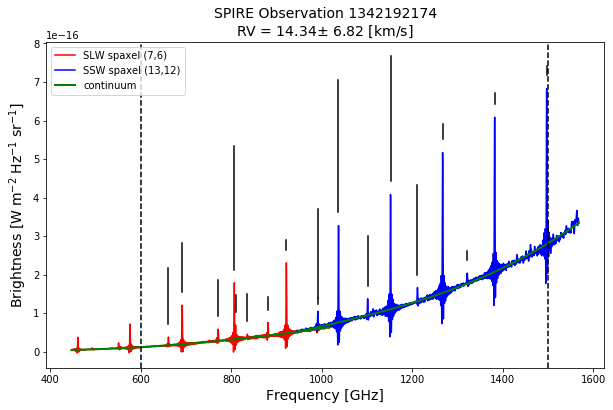

In [29]:
# select lines of interest
freqRange = (600.0, 1500.0)
ind = np.where((features >= min(freqRange)) & (features <= max(freqRange)))[0]

# plotting
fig = plt.figure(0, figsize=(10,6))
plt.clf()
plt.title(f"SPIRE Observation {obsid}\nRV = {np.mean([slw_velocity, ssw_velocity]):.2f}" \
          f"$\\pm$ {np.mean([slw_vel_error, ssw_vel_error]):.2f} [km/s]", fontsize=14)
plt.plot(x_slw, y_slw, 'r', label=f'SLW spaxel ({slw_row[0]},{slw_col[0]})')
plt.plot(x_ssw, y_ssw, 'b', label=f'SSW spaxel ({ssw_row[0]},{ssw_col[0]})')
plt.plot(x_slw, cont_slw, 'g', linewidth=2.0, label='continuum')
plt.plot(x_ssw, cont_ssw, 'g', linewidth=2.0)
for i in ind:
    freq = features[i]
    sn = snr[i]*scale
    ary = array[i]
    base = flux[ary][np.where(min(abs(wave[ary] - freq)) == abs(wave[ary] - freq))[0]]
    plt.plot([freq, freq], [base+offset, base+offset+sn], 'k')
limits = plt.ylim()
plt.plot([min(freqRange), min(freqRange)],[min(limits), max(limits)], '--k')
plt.plot([max(freqRange), max(freqRange)],[min(limits), max(limits)], '--k')
plt.ylim(limits)
plt.xlabel('Frequency [GHz]', fontsize=14)
plt.ylabel('Brightness [$\\mathrm{W \; m^{-2} \; Hz^{-1} \; sr^{-1}}$]', fontsize=14)
plt.legend(loc=0);

### Velocity Maps

For each spectrum processed by the FF, an attempt was made to estimate source radial velocity. These estimates were generated using a variety of methods including: pattern searching for $^{12}$CO rotational emission features, cross-correlation methods where detected features are compared against a template of lines commonly found within the FIR band, and using external references. For more details, please see the release notes linked in the introduction of this document. 

For point-source observations, velocity estimates are stored in the meta data of the per-obsid FF products. For mapping observations, velocity estimates are stored in a velocity map table associated with the per-obsid mapping observation products. Additionally, the main table in each per-obsid FF mapping product contains a column storing radial velocity estimates on a per-feature basis. The SAFECAT also contains a column presenting a radial velocity estimate for each detected feature for the entire FF dataset. In the sample code below, we demonstrate how to generate a velocity map for the already loaded mapping observation.

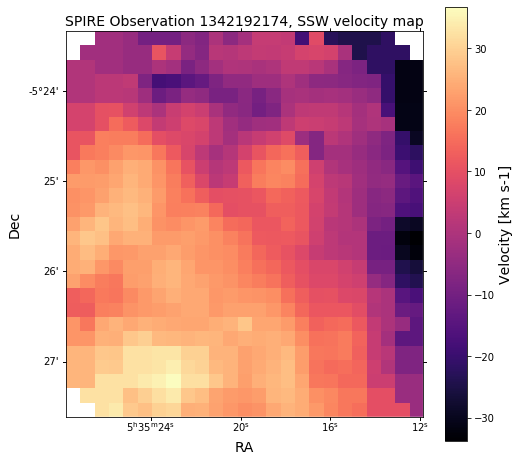

In [30]:
# retrieve World Coordinate System (WCS) object from SPIRE HSA observation
wcs_hsa = WCS(header_ssw)
wcs_new = WCS(naxis=2)

wcs_new.wcs.crpix = wcs_hsa.wcs.crpix[:2]
wcs_new.wcs.cdelt = wcs_hsa.wcs.cdelt[:2]
wcs_new.wcs.crval = wcs_hsa.wcs.crval[:2]
wcs_new.wcs.ctype = ["RA---TAN", "DEC--TAN"]

# because FITS_rec is weird
v_map = []
for row in velocity_map:
    v_map.append(np.array(row))

# plotting
fig = plt.figure(0, figsize=(8,8))
fig.clf()
fig.add_subplot(111, projection=wcs_new)
plt.title(f"SPIRE Observation {obsid}, SSW velocity map", size=14)
plt.imshow(v_map,  origin='lower', cmap='magma')
plt.colorbar().set_label(label=f"Velocity [{header['TUNIT11']}]", size=14)
plt.xlabel('RA', fontsize=14)
plt.ylabel('Dec', fontsize=14)

### Integrated Flux

When analyzing a spectrum, one is often interested in the integrated flux of spectral features. Integrated flux of spectral features is not provided in the FF products because obtaining accurate values typically requires careful analysis of the associated spectra. With this consideration, we demonstrate below a simple approach for obtaining rough estimates of the integrated flux for features detected by the FF. 

The proposed procedure involves fitting detected features using a Sinc model, which closely approximates the empirical line shape of the SPIRE FTS, and extracting the integrated flux analytically from the fitted line parameters. This process is similar to the method employed by the the standard spectral line fitting analysis script used by the Herschel Interactive Processing Environment (HIPE). Typically one would include the continuum in the fitted model, but in our case, we will simply use continuum subtracted spectral data where the fitted continuum is provided by the FF. 

The Sinc function is given by

\begin{equation}
\label{eq:sinc}
f(\nu) = A \frac{\sin(\mathrm{arg})}{\mathrm{arg}} \\
\mathrm{arg} = \frac{\pi(\nu - C)}{W}
\end{equation}

where $A$ and $C$ define the amplitude and centroid of the spectral feature, respectively. The width of the spectral feature, $W$, corresponds the the spectral resolution of the FTS ($\approx$ 1.18 GHz for SPIRE). With these parameters, the integrated line flux of an unresolved spectral feature is

\begin{equation}
\label{eq:integratedFlux}
F_{line} = \int_{-\infty}^{\infty} f(\nu) \; d\nu = AW
\end{equation}

This analytic expression is used to calculate integrated line flux in the code below.

Note: The Sinc function expresses decaying side-lobes which produce non-local effects in the spectrum. For this reasons, fitting a single spectral feature is not recommended. The best and most physically realistic results are obtained when simultaneously fitting all detected features in the spectrum (ie, either the entire SLW or SSW band). We will perform our analysis on the already loaded SLW spectrum from above.

In [31]:
specIn = y_slw - cont_slw # continuum subtracted spectrum
fitFeatures = sorted(FF_data['frequency'][slw_ind][slw_match])
specRes = header0['SLW_HR_convol']['ACTRES']

In [32]:
def sincModel(xdata, amp, cent, width = 1.18): 
    p2 = width/np.pi
    arg = (xdata - cent)/p2
    return amp*np.sin(arg)/arg

In [33]:
totalModel = None
prefs = []

for i in range(len(fitFeatures)):
    pref = f"_{i}"
    prefs.append(pref)
    freq = fitFeatures[i]
    ind = np.where(min(abs(freq - x_slw)) == abs(freq - x_slw))[0]
    amp = specIn[ind]
    newMod = Model(sincModel, prefix=pref)
    newMod.set_param_hint(pref+'amp', value=amp, vary=True)
    newMod.set_param_hint(pref+'cent', value=freq, vary=False)
    newMod.set_param_hint(pref+'width', value=specRes, vary=False) # set vary to True for partially resolved features
    if totalModel == None:
        totalModel = newMod
    else:
        totalModel += newMod
        
result = totalModel.fit(specIn, xdata=x_slw)

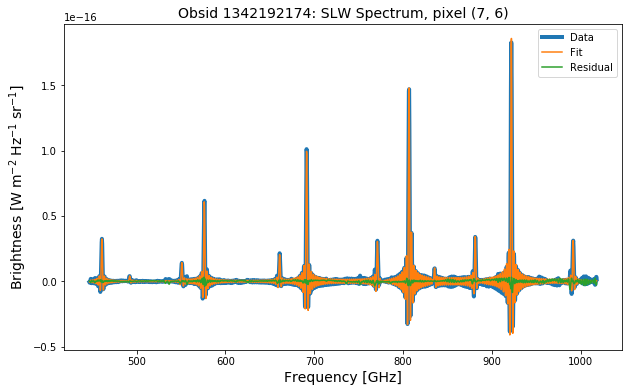

In [34]:
fig = plt.figure(0, figsize=(10,6))
plt.clf()
plt.title(f"Obsid {obsid}: SLW Spectrum, pixel {slw_row[0], slw_col[0]}", fontsize=14)
plt.plot(x_slw, specIn, linewidth=4.0, label='Data')
plt.plot(x_slw, result.best_fit, label='Fit')
plt.plot(x_slw, result.residual, label='Residual')
plt.xlabel('Frequency [GHz]', fontsize=14)
plt.ylabel('Brightness [$\\mathrm{W \; m^{-2} \; Hz^{-1} \; sr^{-1}}$]', fontsize=14)
plt.legend(loc=0)
plt.show()

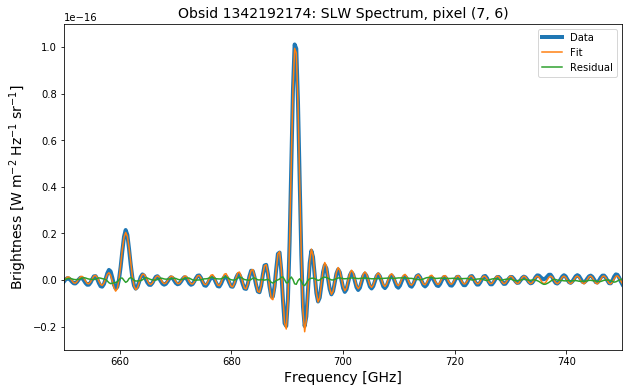

In [35]:
#
# zoom in around a particular feature
#
fig = plt.figure(0, figsize=(10,6))
plt.clf()
plt.title(f"Obsid {obsid}: SLW Spectrum, pixel {slw_row[0], slw_col[0]}", fontsize=14)
plt.plot(x_slw, specIn, linewidth=4.0, label='Data')
plt.plot(x_slw, result.best_fit, label='Fit')
plt.plot(x_slw, result.residual, label='Residual')
plt.xlim((650,750))
plt.ylim((-0.3e-16,1.1e-16))
plt.xlabel('Frequency [GHz]', fontsize=14)
plt.ylabel('Brightness [$\\mathrm{W \; m^{-2} \; Hz^{-1} \; sr^{-1}}$]', fontsize=14)
plt.legend(loc=0)
plt.show()

In [36]:
# and print the fit results
fitPars = result.params
print('Frequency [GHz]     Flux [W m-2 sr-1]     Flux Error [W m-2 sr-1]\n')
for pref in prefs:
    amp = fitPars[f'{pref}amp']
    freq = fitPars[f'{pref}cent']
    width = fitPars[f'{pref}width']
    flux = amp.value*1e9*width.value
    fluxErr = flux*np.sqrt((amp.stderr/amp.value)**2 + (width.stderr/width.value)**2)
    print(f"{freq.value:10.2f} {flux:21.3e} {fluxErr:25.3e}\n")
#

Frequency [GHz]     Flux [W m-2 sr-1]     Flux Error [W m-2 sr-1]

    461.01             3.868e-08                 5.592e-10

    492.14             4.431e-09                 5.584e-10

    550.94             1.778e-08                 5.583e-10

    576.28             7.295e-08                 5.582e-10

    661.08             2.551e-08                 5.582e-10

    691.44             1.203e-07                 5.582e-10

    771.13             3.658e-08                 5.581e-10

    806.62             1.768e-07                 5.611e-10

    809.30             2.260e-08                 5.612e-10

    835.11             1.111e-08                 5.582e-10

    881.25             3.938e-08                 5.582e-10

    921.75             2.232e-07                 5.582e-10

    991.32             3.682e-08                 5.587e-10



In the above example we have assumed the spectral features are not resolved. When analyzing partially or fully resolved spectral features, best results are obtained when modeling the spectral features as Sinc convolved Gaussians. However, for a quick estimate of integrated flux, one can simply set the `vary` keyword for the `width` variable in the fitter object to `True`. The large majority of spectral features in the SPIRE FTS dataset are unresolved and the above script should be sufficient in most cases. 

### Unit Conversion for Integrated Flux

It is often convenient to express integrated flux in alternative units. Here we summarize how to convert from standard SPIRE FTS integrated line flux units to a few other commonly encountered units. For a more comprehensive overview, please see [SPIRE FTS: converting integrated line fluxes to alternative units](https://www.cosmos.esa.int/web/herschel/legacy-documentation-spire-level-2).

#### Point Source Calibration

Since point source calibrated spectra in SPIRE are presented in units of Janskys, employing the analytical equation for integrated line flux returns units of [Jy GHz]. To obtain integrated line flux in SI units use

\begin{equation}
\label{eq:flux_Wm2}
F_{\mathrm{line}} = AW \times 10^{-17} \qquad [\mathrm{W \; m^{-2}}]
\end{equation}

where $A$ is in units of Jy and $W$ is in units of GHz. All the following unit conversions for point source calibrated spectra will be done with respect to $F_{\mathrm{line}}$. 

* $[\mathrm{W \; m^{-2}}] \rightarrow [\mathrm{erg \; cm^{-2} \; s^{-1}}]$ 

This conversion requires only a multiplicative factor,

\begin{equation}
\label{eq:flux_ergcm2s}
F' = F_{\mathrm{line}} \times 10^3 \qquad [\mathrm{erg \; cm^{-2} \; s^{-1}}]
\end{equation}

* $[\mathrm{W \; m^{-2}}] \rightarrow [\mathrm{Jy \; km \; s^{-1}}]$

This conversion requires a multiplicative factor and the rest frame emission frequency, $\nu_0$, of the line in question using units of GHz.

\begin{equation}
\label{eq:flux_jykms1}
F' = \frac{F_{\mathrm{line}} \; (9.418 \times 10^{19})}{\nu_0} \qquad [\mathrm{Jy \; km \; s^{-1}}]
\end{equation}

Alternatively, one can use the rest frame emission wavelength, $\lambda_0$, of the line in question using units of $\mu\mathrm{m}$.

\begin{equation}
\label{eq:flux_jykms2}
F' = F_{\mathrm{line}} \; \lambda_0 \; (\pi \times 10^{7}) \qquad [\mathrm{Jy \; km \; s^{-1}}]
\end{equation}

* $[\mathrm{W \; m^{-2}}] \rightarrow [\mathrm{K \; km \; s^{-1}}]$

The temperature unit Kelvins in the desired units is in reference to the so called "brightness temperature" and is a useful quantity for FIR/submm and radio astronomy. This conversion is somewhat more complicated in that it requires knowledge of the frequency dependent SPIRE FTS beam width. We use $\theta_b(\nu)$, in units of arcseconds, to denote the frequency dependent Full Width at Half Maximum (FWHM) of the beam. For SPIRE, this empirically derived curve can be obtained from the following link http://archives.esac.esa.int/hsa/legacy/ADP/PSF/SPIRE/SPIRE-S/. Both the SPIRE SLW and SSW detector arrays have their own curves. The conversion is then

\begin{equation}
\label{eq:flux_kkms}
F' = \frac{F_{\mathrm{line}} \; (1.149 \times 10^{29})}{\theta_b^2(\nu) \; \nu_0^3} \qquad [\mathrm{K \; km \; s^{-1}}]
\end{equation}

Note that $\nu_0$ is again the rest frame emission frequency of the line in question in units of GHz, and $\theta_b(\nu)$ is the beam FWHM at the detected frequency of the line in question. Since this conversion is nontrivial, we provide a sample conversion below.

In [37]:
freq_det = 482.1 # feature detection frequency [GHz]
freq_0 = 1000.0 # rest frame frequency for detected feature [GHz]
amp = 1 # amplitude of detected feature [Jy]
width = 1.18448225 # width of sinc function [GHz]
#
# download the FTS beam FWHM as a function of frequency
#
url = 'http://archives.esac.esa.int/hsa/legacy/ADP/PSF/SPIRE/SPIRE-S/fwhm_omega_SLW_HR.csv'
beam_slw = Table.read(url,comment="\s*#",data_start=4)
#
freq = beam_slw['frequency']
fwhm = beam_slw['FWHM']
# beam FWHM at detection frequency, using linear interpolation
theta = np.interp(freq_det, freq, fwhm)
# calculated integrated line flux [W m-2]
F_line = amp*width*1e-17
# conversion to [K km s-1]
F_ = F_line*1.149e29/theta**2/freq_0**3

print(f"Integrated line flux:\n F_line = {F_line:.2e} [W m-2]\n F_ = {F_:.2f} [K km s-1]")

Integrated line flux:
 F_line = 1.18e-17 [W m-2]
 F_ = 0.85 [K km s-1]


#### Extended Source Calibration

Since extended source calibrated spectra in SPIRE are presented in units of [W m-2 Hz-1 sr-1], employing the analytical equation for integrated line flux returns units of [W GHz m-2 Hz-1 sr-1]. To obtain integrated line flux in SI units use

\begin{equation}
\label{eq:flux_Wm2sr1}
F_{\mathrm{line}} = AW \times 10^{9} \qquad [\mathrm{W \; m^{-2} \; sr^{-1}}]
\end{equation}

where $A$ is the amplitude of the feature in units of [W m-2 Hz-1 sr-1], and $W$ is the width of the feature in units of GHz.

*  $[\mathrm{W \; m^{-2} \; sr^{-1}}] \rightarrow [K]$

The desired temperature units of Kelvins is again in relation to the so called "brightness temperature". For extended source calibrated spectra, the conversion requires simply a multiplicative factor and the emission rest frequency, $\nu_0$, of the spectral feature in question in units of GHz. The conversion is given by

\begin{equation}
\label{eq:flux_K}
F' = \frac{F_{\mathrm{line}} (1.04 \times 10^{12})}{\nu_0^2} \qquad [K]
\end{equation}

### Conclusion

The Herschel/SPIRE Spectral Feature Finder is an automated tool which attempts to detect significant spectral features within SPIRE FTS data. This tool and the resulting dataset is designed to help with preliminary analysis and data mining of SPIRE spectral data and is not intended to replaced detailed analysis. In this document we have demonstrated how to retrieve FF products through a Python interface and how to query these products for features meeting specific search criteria. We also outlined simple methods for displaying FF results including plotting FF features and fitted continua over the SPIRE spectra obtained from the HSA, and displaying velocity maps for mapping observations. Finally, we provided sample code for how to extract integrated line flux for detected spectral features and outlined conversion methods for obtaining the integrated flux in other common units.